In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
from datetime import date
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.eval_measures import rmse, meanabs
%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

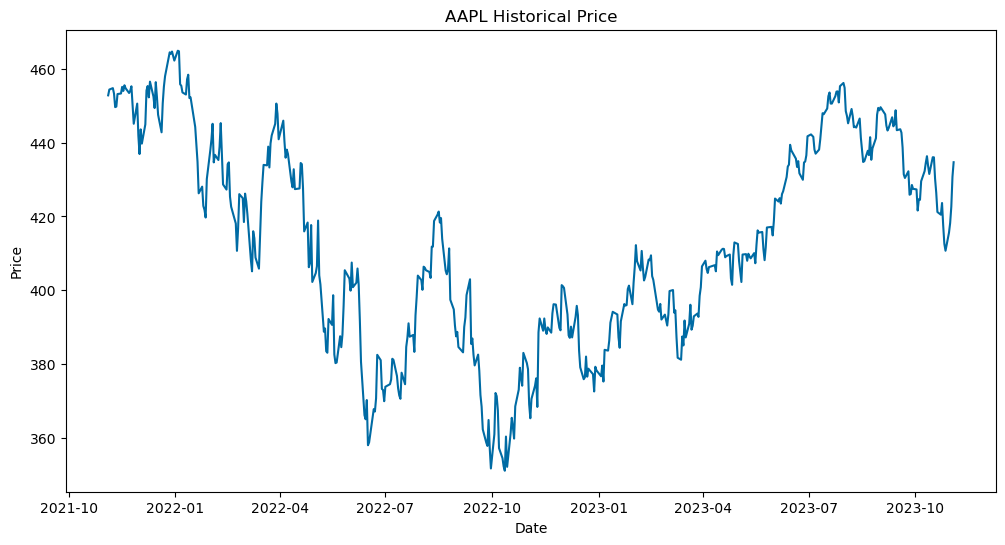

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='24mo')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Historical Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=410.823165, mean2=414.278171, mean_percent_diff=0.840996
variance1=1017.748832, variance2=527.935105, var_percent_diff=-48.127172


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -2.203446
p-value: 0.204997
Critical Values:
{'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(0.8047069129733099, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.80
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


##### P-value < .05; therefore, not stationary

### Transform into stationary series

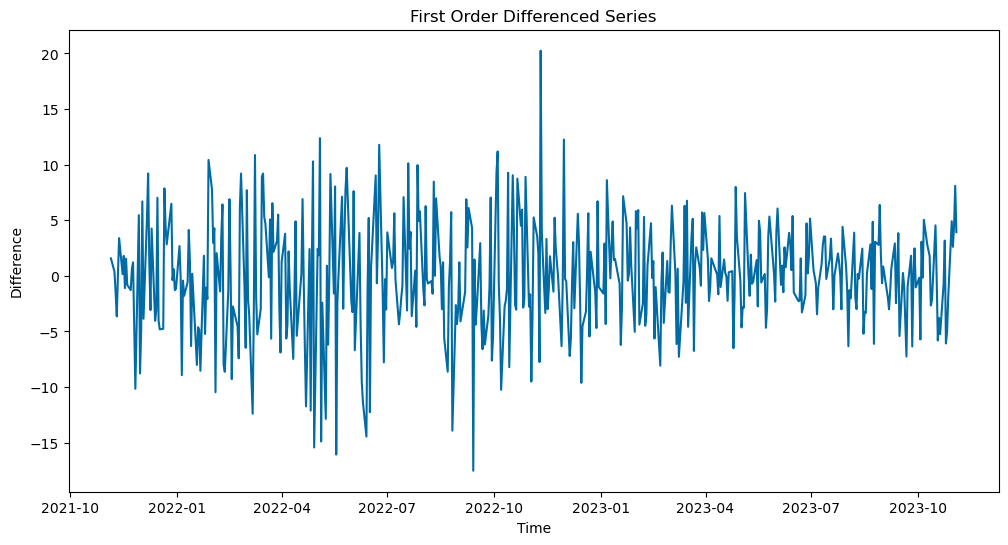

In [8]:
X['Difference'] = X.diff()
plt.figure(figsize=(12,6))
plt.plot(X['Difference'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

In [9]:
result = adfuller(X.Difference.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -21.970217
p-value: 0.000000
Critical Values:
{'1%': -3.443470002903981, '5%': -2.867326248740681, '10%': -2.569851849873108}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
close = aapl.history(period='36mo')['Close']
print(len(close))
close_train = close.iloc[:506]
close_valid = close.iloc[-260:]

755


In [12]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=260)
ses_rmse = rmse(close_valid, ses_pred)

/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

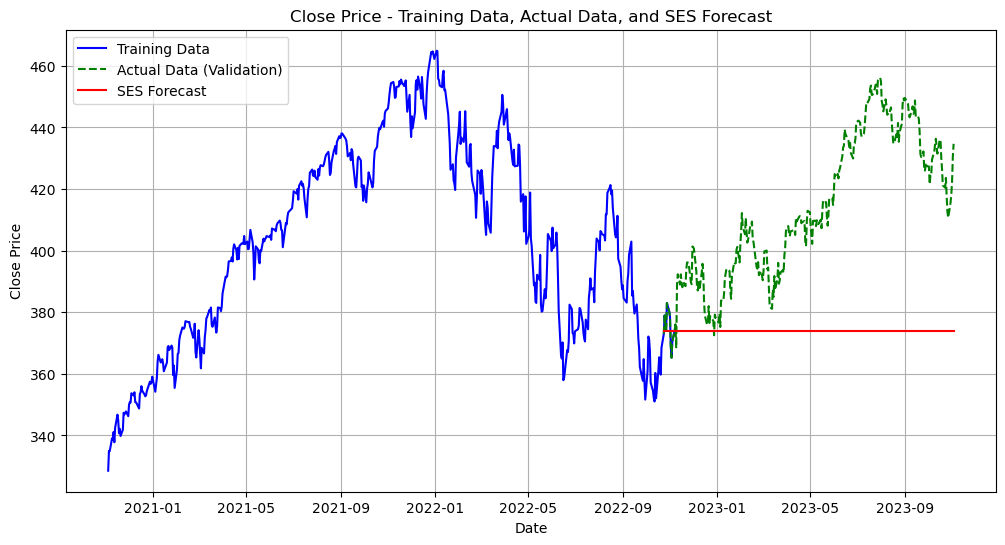

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
aapl.income_stmt

""


In [15]:
aapl.quarterly_income_stmt

""


In [16]:
aapl.balance_sheet

""


In [17]:
aapl.quarterly_cashflow

""


In [18]:
aapl.major_holders

,0,1
0,Previous Close,430.76
1,Open,433.14
2,Bid,435.23 x 900
3,Ask,435.17 x 1300
4,Day's Range,433.01 - 436.29
5,52 Week Range,370.00 - 459.44
6,Volume,100024745
7,Avg. Volume,83155864


In [19]:
aapl.institutional_holders

,0,1
0,Net Assets,400.96B
1,NAV,430.68
2,PE Ratio (TTM),21.90
3,Yield,1.52%
4,YTD Daily Total Return,13.90%
5,Beta (5Y Monthly),1.00
6,Expense Ratio (net),0.09%
7,Inception Date,1993-01-22


In [20]:
aapl.mutualfund_holders

In [21]:
aapl.news

[{'uuid': '5dbbc2a4-ba53-45f1-b617-4119c3765df2',
  'title': 'Stock market news today: Stocks rise as jobs growth cools more than expected',
  'publisher': 'Yahoo Finance',
  'link': 'https://finance.yahoo.com/news/stock-market-news-today-stocks-rise-as-jobs-growth-cools-more-than-expected-133705314.html',
  'providerPublishTime': 1699042040,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/XVZMrgaEeqlbgRQ6B9rFAw--~B/aD00MDAwO3c9NjAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2023-11/ec449170-79cc-11ee-97f3-6d9feb44432d',
     'width': 6000,
     'height': 4000,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/ZlWVoDQ5PrGH2QI3NsseYw--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://s.yimg.com/os/creatr-uploaded-images/2023-11/ec449170-79cc-11ee-97f3-6d9feb44432d',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['^DJI', '^IXIC', 'QQQ', 'S

In [22]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [23]:
startdate = datetime.datetime(2020,3,16)
today = date.today()
enddate = today

In [24]:
indices = web.get_data_yahoo(y_symbols, start=startdate, end=enddate)
stocks = web.get_data_yahoo(stocks, start=startdate, end=enddate)

NameError: name 'web' is not defined

In [ ]:
stocks

In [ ]:
aapl.history(period='1mo')

In [ ]:
aapl.get_shares_full(start="2022-01-01", end=None)

In [ ]:
opt_df = aapl.option_chain('2023-11-10')
call = opt_df.calls
put = opt_df.puts
put

In [ ]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [ ]:
put.describe()

In [ ]:
df_temp

In [ ]:
aapl.options